# <Font color = 'indianred'>**Load Libraries/Install Software**

In [ ]:
if 'google.colab' in str(get_ipython()):
    from google.colab import drive
    drive.mount('/content/drive')

    !pip install torchtext --upgrade -qq
    !pip install torchmetrics -qq
    !pip install torchinfo -qq

    basepath = '/content/drive/MyDrive/NLP/Lecture 4/data'



Mounted at /content/drive
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 764.8/764.8 kB 10.8 MB/s eta 0:00:00


In [ ]:
!pip install torchinfo -qq

In [ ]:
# Importing PyTorch library for tensor computations and neural network modules
import torch
import torch.nn as nn
import torch.nn.functional as F

# For working with textual data vocabularies and for displaying model summaries
from torchtext.vocab import vocab
from torchinfo import summary

# General-purpose Python libraries for random number generation and numerical operations
import random
import numpy as np

# Utilities for efficient serialization/deserialization of Python objects and for element tallying
import joblib
from collections import Counter

# For creating lightweight attribute classes and for partial function application
from types import SimpleNamespace
from functools import partial

# For filesystem path handling, generating and displaying confusion matrices, and date-time manipulations
from pathlib import Path
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from datetime import datetime

# For plotting and visualization
import matplotlib.pyplot as plt



# <Font color = 'indianred'>**Specify Project Folders**

In [ ]:
base_folder = Path(basepath)
data_folder = base_folder/'datasets/aclImdb'
model_folder = base_folder/'models/nlp_fall_2023/imdb/nn'
custom_functions = base_folder/'custom-functions'

In [ ]:
model_folder.mkdir(exist_ok=True)

# <Font color = 'indianred'>**Data Preparation**

For this notebook, we will use IMDB movie review dataset. <br>
LInk for complete dataset: http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz.

We downloaded the dataset in the previous lecture 2 notebook (notebook: 3_Faster_tokenization_spacy_final.ipynb)

We created csv files in Lecture 2 -- train.csv and test.csv file. The files are availible in Lecture2/data folder from eLearning. I have applied the custom pre=processor and cleaned the data set for this lecture. I pickled the datasets and saved them as files. The files are available in data folder. We will download the following files as well.

- 'x_train_cleaned_bag_of_words.pkl'
- 'x_valid_cleaned_bag_of_words.pkl'
- 'x_test_cleaned_bag_of_words.pkl'

##  <Font color = 'indianred'>**Load cleaned arrays from indianredd files using joblib**

In [ ]:
data_folder = '/content/drive/MyDrive/NLP/Lecture 4/data'

In [ ]:
X_train_cleaned_file = data_folder + '/x_train_cleaned_bag_of_words.pkl'
X_valid_cleaned_file = data_folder + '/x_valid_cleaned_bag_of_words.pkl'
X_test_cleaned_file = data_folder + '/x_test_cleaned_bag_of_words.pkl'

In [ ]:
X_train_cleaned, y_train = joblib.load(X_train_cleaned_file)
X_valid_cleaned, y_valid = joblib.load(X_valid_cleaned_file)
X_test_cleaned, y_test = joblib.load(X_test_cleaned_file)

In [ ]:
type(y_train)

numpy.ndarray

In [ ]:
y_train[1]

0

In [ ]:
type(X_train_cleaned)

list

## <Font color = 'indianred'>**Custom Dataset Class**

In [ ]:
class CustomDataset(torch.utils.data.Dataset):
    """
    Custom Dataset class for loading IMDB reviews and labels.

    Attributes:
        X (numpy.ndarray): Feature data, an array of texts.
        y (list or array-like): Target labels.
    """

    def __init__(self, X, y):
        """
        Initialize the dataset with feature and target data.

        Args:
            X (list or array-like): The feature data (texts).
            y (list or array-like): The target labels.
        """
        # Converting the feature data to a NumPy array for consistency
        self.X = np.array(X)

        # Storing the target labels
        self.y = y

    def __len__(self):
        """
        Return the number of samples in the dataset.

        Returns:
            int: The total number of samples.
        """
        return len(self.X)

    def __getitem__(self, idx):
        """
        Fetch and return a single sample from the dataset at the given index.

        Args:
            idx (int): Index of the sample to fetch.

        Returns:
            tuple: A tuple containing the label and the text for the sample.
        """
        # Retrieve the text and corresponding label from the dataset using the index
        texts = self.X[idx]
        labels = self.y[idx]

        # Packing them into a tuple before returning
        sample = (labels, texts)

        return sample


In [ ]:
trainset = CustomDataset(X_train_cleaned, y_train)
validset = CustomDataset(X_valid_cleaned, y_valid)
testset = CustomDataset(X_test_cleaned, y_test)

In [ ]:
trainset[1][1]

'horror movie alright let start kate main goal include get lay george clooney look good screw got to love 3 amazingly good chance finish sicko instead run mean wanna bring guy 10 minute late mean guy try rape not movie main character sad idiot mean honestly sympathy guy finish meet night movie keep go result lose credibility'

In [ ]:
trainset[1][0]

0

## <Font color = 'indianred'>**Create Vocab**

In [ ]:
def get_vocab(dataset, min_freq=1):
    """
    Generate a vocabulary from a dataset.

    Args:
        dataset (list of tuple): List of tuples where each tuple contains a label and a text.
        min_freq (int): The minimum frequency for a token to be included in the vocabulary.

    Returns:
        torchtext.vocab.Vocab: Vocabulary object.
    """
    # Initialize a counter object to hold token frequencies
    counter = Counter()

    # Update the counter with tokens from each text in the dataset
    for (l_, text) in dataset:
        counter.update(str(text).split())

    # Create a vocabulary using the counter object
    # Tokens that appear fewer times than `min_freq` are excluded
    my_vocab = vocab(counter, min_freq=min_freq)

    # Insert a '<unk>' token at index 0 to represent unknown words
    my_vocab.insert_token('<unk>', 0)

    # Set the default index to 0
    # This ensures that any unknown word will be mapped to '<unk>'
    my_vocab.set_default_index(0)

    return my_vocab


vocab should always be created based on trainset

In [ ]:
imdb_vocab = get_vocab(trainset, min_freq=2)

In [ ]:
len(imdb_vocab)

36153

In [ ]:
imdb_vocab.get_itos()[0:5]

['<unk>', 'george', 'brent', 'reporter', 'send']

In [ ]:
imdb_vocab['abracadabra']

0

## <Font color = 'indianred'>**Collate_fn for Data Loaders**

In [ ]:
# Creating a function that will be used to get the indices of words from vocab
def text_pipeline(x, vocab):
    """Converts text to a list of indices using a vocabulary dictionary"""
    return [vocab[token] for token in str(x).split()]

In [ ]:
def collate_batch(batch, my_vocab):
    """
    Collates a batch of samples into tensors of labels, texts, and offsets.

    Parameters:
        batch (list): A list of tuples, each containing a label and a text.

    Returns:
        tuple: A tuple containing three tensors:
               - Labels tensor
               - Concatenated texts tensor
               - Offsets tensor indicating the start positions of each text in the concatenated tensor
    """
    # Unpack the batch into separate lists for labels and texts
    labels, texts = zip(*batch)

    # Convert the list of labels into a tensor of dtype int32
    labels = torch.tensor(labels, dtype=torch.long)

    # Convert the list of texts into a list of lists; each inner list contains the vocabulary indices for a text
    list_of_list_of_indices = [text_pipeline(text, my_vocab) for text in texts]

    # Compute the offsets for each text in the concatenated tensor
    offsets = [0] + [len(i) for i in list_of_list_of_indices]
    offsets = torch.tensor(offsets[:-1]).cumsum(dim=0)

    # Concatenate all text indices into a single tensor
    texts = torch.cat([torch.tensor(i, dtype=torch.int64) for i in list_of_list_of_indices])

    return (texts, offsets), labels

## <Font color = 'indianred'>**Check Data Loaders**

Let us check if our collate function is working by creating a dataloader

In [ ]:
batch_size = 2
check_loader = torch.utils.data.DataLoader(dataset=trainset,
                                           batch_size=batch_size,
                                           shuffle=True,
                                           collate_fn=partial(collate_batch, my_vocab = imdb_vocab),
                                           )

In [ ]:
torch.manual_seed(22)
for (text, offset), label in check_loader:
    print(text, offset, label)
    break


tensor([ 2644, 10417,  1560,    42,   205,  4201,  2225, 11426,   688,  6568,
          879,   435,   655,  1514,  6239,  1451,     0,  5564, 15153,   239,
        12797, 15152,    51,   229,   679,  5201, 14646,  1215,   402,   814,
           75,   112,    37,   137,   210,   206,   226,  4572,  1538,  9318,
          606,  9338, 13643,  1666,    75,   255,  1561,   112,  5459, 24297,
          231,    42,    27,    75,   868,  2704,  4721,  2815,  2826,    42,
         1555,    42,  1227]) tensor([ 0, 30]) tensor([0, 0])


# <Font color = 'indianred'>**Model**
embedding_layer-->linear--> ReLU -->dropout --> batch norm --> linear-->ReLu-->Dropout--> batchnorm ---> linear layer

In [ ]:
class CustomBlock(nn.Module):
    def __init__(self, input_dim, output_dim, drop_prob):

        super().__init__()

        self.layers = nn.Sequential(
            nn.Linear(input_dim, output_dim),
            nn.BatchNorm1d(num_features=output_dim),
            nn.ReLU(),
            nn.Dropout(p=drop_prob),

        )
    def forward(self, x):
      return self.layers(x)



## <Font color = 'indianred'>**Model without EmbeddingBag layer**

In [ ]:
# model without embedding layer
# assume we have used tfidf to create x_tensors, y_tensors
# we have used max_df = 500, number of inputs = 500
model_no_embedding = nn.Sequential(
    CustomBlock(500, 200, 0.5),
    CustomBlock(200, 100, 0.5),
    nn.Linear(100, 2)
    )

In [ ]:
summary(model_no_embedding, (1, 500))

Layer (type:depth-idx)                   Output Shape              Param #
Sequential                               [1, 2]                    --
├─CustomBlock: 1-1                       [1, 200]                  --
│    └─Sequential: 2-1                   [1, 200]                  --
│    │    └─Linear: 3-1                  [1, 200]                  100,200
│    │    └─BatchNorm1d: 3-2             [1, 200]                  400
│    │    └─ReLU: 3-3                    [1, 200]                  --
│    │    └─Dropout: 3-4                 [1, 200]                  --
├─CustomBlock: 1-2                       [1, 100]                  --
│    └─Sequential: 2-2                   [1, 100]                  --
│    │    └─Linear: 3-5                  [1, 100]                  20,100
│    │    └─BatchNorm1d: 3-6             [1, 100]                  200
│    │    └─ReLU: 3-7                    [1, 100]                  --
│    │    └─Dropout: 3-8                 [1, 100]                  --
├─Li

## <Font color = 'indianred'>**Model with EmbeddingBag layer**





## <Font color = 'indianred'>**Model with EmbeddingBag layer - Option1**

In [ ]:
class EmbeddingBagWrapper(nn.Module):
    def __init__(self, vocab_size, embedding_dim):
        super().__init__()
        self.embedding_bag = nn.EmbeddingBag(vocab_size, embedding_dim)

    def forward(self, input_tuple):
        data, offsets = input_tuple
        return self.embedding_bag(data, offsets)

# Define the sequential model
vocab_size = 5
embed_dim = 500
model_embedding_1 = nn.Sequential(
    EmbeddingBagWrapper(vocab_size, embed_dim ),
    CustomBlock(embed_dim , 200, 0.5),
    CustomBlock(200, 100, 0.5),
    nn.Linear(100, 2)
    )


In [ ]:
# Define the device
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Move the model to the device
model_embedding_1 = model_embedding_1.to(device)

# Generate some dummy input data and offsets, and move them to the device
data = torch.LongTensor([1, 2, 4, 5, 4]).to(device)
offsets = torch.LongTensor([0, 2, 4]).to(device)

# Generate summary
summary(model_embedding_1, input_data=[(data, offsets)], device=device)


Layer (type:depth-idx)                   Output Shape              Param #
Sequential                               [3, 2]                    --
├─EmbeddingBagWrapper: 1-1               [3, 500]                  --
│    └─EmbeddingBag: 2-1                 [3, 500]                  2,500
├─CustomBlock: 1-2                       [3, 200]                  --
│    └─Sequential: 2-2                   [3, 200]                  --
│    │    └─Linear: 3-1                  [3, 200]                  100,200
│    │    └─BatchNorm1d: 3-2             [3, 200]                  400
│    │    └─ReLU: 3-3                    [3, 200]                  --
│    │    └─Dropout: 3-4                 [3, 200]                  --
├─CustomBlock: 1-3                       [3, 100]                  --
│    └─Sequential: 2-3                   [3, 100]                  --
│    │    └─Linear: 3-5                  [3, 100]                  20,100
│    │    └─BatchNorm1d: 3-6             [3, 100]                  200
│

In [ ]:
# Test the model
# Move the model to the device
model_embedding_1 = model_embedding_1.to(device)

# Generate some dummy input data and offsets, and move them to the device
# we will pass text as input, collate function will create data and offsets
data = torch.LongTensor([1, 2, 4, 5, 4]).to(device)
offsets = torch.LongTensor([0, 2, 4]).to(device)

# Since nn.Sequential expects a single input, we pack data and offsets into a tuple
output = model_embedding_1((data, offsets))

print(output)


tensor([[ 0.5956, -0.1449],
        [ 0.5128,  0.0181],
        [ 0.4469, -0.5581]], device='cuda:0', grad_fn=<AddmmBackward0>)


## <Font color = 'indianred'>**Model with EmbeddingBag layer - Option2**

In [ ]:
class CustomMLP(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim1, hidden_dim2, drop_prob1, drop_prob2, num_outputs):
        super().__init__()

        self.embedding_bag = nn.EmbeddingBag(vocab_size, embedding_dim)
        self.layers = nn.Sequential(
            CustomBlock(embedding_dim , hidden_dim1, drop_prob1),
            CustomBlock(hidden_dim1, hidden_dim2, drop_prob2),
            nn.Linear(hidden_dim2, num_outputs)
        )

    def forward(self, input_tuple):
        data, offsets = input_tuple
        embed_out = self.embedding_bag(data, offsets)
        out = self.layers(embed_out)

        return out

In [ ]:
# Define the device
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Define the sequential model
model_embedding_2 = CustomMLP(vocab_size=7 , embedding_dim=10, hidden_dim1=5, hidden_dim2=3, drop_prob1=0.5, drop_prob2=0.5, num_outputs=2)

# Move the model to the device
model_embedding_2 = model_embedding_2.to(device)

# Generate some dummy input data and offsets, and move them to the device
data = torch.tensor([1, 2, 4, 5, 4], dtype = torch.int32).to(device)
offsets = torch.tensor([0, 2, 4], dtype = torch.int32).to(device)

# Generate summary
summary(model_embedding_2, input_data=[(data, offsets)], device=device, depth =4)


Layer (type:depth-idx)                   Output Shape              Param #
CustomMLP                                [3, 2]                    --
├─EmbeddingBag: 1-1                      [3, 10]                   70
├─Sequential: 1-2                        [3, 2]                    --
│    └─CustomBlock: 2-1                  [3, 5]                    --
│    │    └─Sequential: 3-1              [3, 5]                    --
│    │    │    └─Linear: 4-1             [3, 5]                    55
│    │    │    └─BatchNorm1d: 4-2        [3, 5]                    10
│    │    │    └─ReLU: 4-3               [3, 5]                    --
│    │    │    └─Dropout: 4-4            [3, 5]                    --
│    └─CustomBlock: 2-2                  [3, 3]                    --
│    │    └─Sequential: 3-2              [3, 3]                    --
│    │    │    └─Linear: 4-5             [3, 3]                    18
│    │    │    └─BatchNorm1d: 4-6        [3, 3]                    6
│    │    │    └

In [ ]:
# Test the model
# Move the model to the device
model_embedding_2 = model_embedding_2.to(device)

# Generate some dummy input data and offsets, and move them to the device
# we will pass text as input, collate function will create data and offsets
data = torch.LongTensor([1, 2, 4, 5, 4]).to(device)
offsets = torch.LongTensor([0, 2, 4]).to(device)

# Since nn.Sequential expects a single input, we pack data and offsets into a tuple
output = model_embedding_2((data, offsets))

print(output)

tensor([[-0.2763,  0.2234],
        [-0.2763,  0.2234],
        [-0.2763,  0.2234]], device='cuda:0', grad_fn=<AddmmBackward0>)


# <Font color = 'indianred'>**Model Training Functions**




## <Font color = 'indianred'>**Step Function**

In [ ]:
def step(inputs, targets, model, device, loss_function=None, optimizer=None):
    """
    Performs a forward and backward pass for a given batch of inputs and targets.

    Parameters:
    - inputs (torch.Tensor): The input data for the model.
    - targets (torch.Tensor): The true labels for the input data.
    - model (torch.nn.Module): The neural network model.
    - device (torch.device): The computing device (CPU or GPU).
    - loss_function (torch.nn.Module, optional): The loss function to use.
    - optimizer (torch.optim.Optimizer, optional): The optimizer to update model parameters.

    Returns:
    - loss (float): The computed loss value (only if loss_function is not None).
    - outputs (torch.Tensor): The predictions from the model.
    - correct (int): The number of correctly classified samples in the batch.
    """
    # Move the model and data to the device
    model = model.to(device)
    inputs = tuple(input_tensor.to(device)
                            for input_tensor in inputs)

    targets = targets.to(device)

    # Step 1: Forward pass to get the model's predictions
    outputs = model(inputs)

    # Step 2: Compute the loss using the provided loss function
    if loss_function:
        loss = loss_function(outputs, targets)

    # Step 2: Calculate the number of correctly classified samples
    predicted = torch.argmax(outputs.data, 1)
    correct = (predicted == targets).sum().item()

    # Step 3 and 4: Perform backward pass and update model parameters if an optimizer is provided
    if optimizer:
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Return relevant metrics
    if loss_function:
        return loss, outputs, correct
    else:
        return outputs, correct


## <Font color = 'indianred'>**Train_Epoch Function**

In [ ]:
def train_epoch(train_loader, model, device, loss_function, optimizer):
    """
    Trains the model for one epoch using the provided data loader and updates the model parameters.

    Parameters:
    - train_loader (torch.utils.data.DataLoader): DataLoader object for the training set.
    - model (torch.nn.Module): The neural network model to be trained.
    - device (torch.device): The computing device (CPU or GPU).
    - loss_function (torch.nn.Module): The loss function to use for training.
    - optimizer (torch.optim.Optimizer): The optimizer to update model parameters.

    Returns:
    - train_loss (float): Average training loss for the epoch.
    - train_acc (float): Training accuracy for the epoch.
    """
    # Set the model to training mode
    model.train()

    # Initialize variables to track running training loss and correct predictions
    running_train_loss = 0.0
    running_train_correct = 0

    # Iterate over all batches in the training data
    for inputs, targets in train_loader:
        # Perform a forward and backward pass, updating model parameters
        loss, _, correct = step(inputs, targets, model, device, loss_function, optimizer)

        # Update running loss and correct predictions counter
        running_train_loss += loss.item()
        running_train_correct += correct

    # Compute average loss and accuracy for the entire training set
    train_loss = running_train_loss / len(train_loader)
    train_acc = running_train_correct / len(train_loader.dataset)

    return train_loss, train_acc


## <Font color = 'indianred'>**Val_Epoch Function**

In [ ]:
def val_epoch(valid_loader, model, device, loss_function):
    """
    Validates the model for one epoch using the provided data loader.

    Parameters:
    - valid_loader (torch.utils.data.DataLoader): DataLoader object for the validation set.
    - model (torch.nn.Module): The neural network model to be validated.
    - device (torch.device): The computing device (CPU or GPU).
    - loss_function (torch.nn.Module): The loss function to evaluate the model.

    Returns:
    - val_loss (float): Average validation loss for the epoch.
    - val_acc (float): Validation accuracy for the epoch.
    """
    # Set the model to evaluation mode
    model.eval()

    # Initialize variables to track running validation loss and correct predictions
    running_val_loss = 0.0
    running_val_correct = 0

    # Disable gradient computation
    with torch.no_grad():
        # Iterate over all batches in the validation data
        for inputs, targets in valid_loader:
            # Perform a forward pass to get loss and number of correct predictions
            loss, _, correct = step(inputs, targets, model, device, loss_function, optimizer=None)

            # Update running loss and correct predictions counter
            running_val_loss += loss.item()
            running_val_correct += correct

    # Compute average loss and accuracy for the entire validation set
    val_loss = running_val_loss / len(valid_loader)
    val_acc = running_val_correct / len(valid_loader.dataset)

    return val_loss, val_acc


## <Font color = 'indianred'>**Train Function**

In [ ]:
def train(train_loader, valid_loader, model, optimizer, loss_function, epochs, device):
    """
    Trains and validates the model, and returns history of train and validation metrics.

    Parameters:
    - train_loader (torch.utils.data.DataLoader): DataLoader for the training set.
    - valid_loader (torch.utils.data.DataLoader): DataLoader for the validation set.
    - model (torch.nn.Module): Neural network model to train.
    - optimizer (torch.optim.Optimizer): Optimizer algorithm.
    - loss_function (torch.nn.Module): Loss function to evaluate the model.
    - epochs (int): Number of epochs to train the model.
    - device (torch.device): The computing device (CPU or GPU).

    Returns:
    - train_loss_history (list): History of training loss for each epoch.
    - train_acc_history (list): History of training accuracy for each epoch.
    - valid_loss_history (list): History of validation loss for each epoch.
    - valid_acc_history (list): History of validation accuracy for each epoch.
    """

    # Initialize lists to store metrics for each epoch
    train_loss_history = []
    valid_loss_history = []
    train_acc_history = []
    valid_acc_history = []

    # Loop over the number of specified epochs
    for epoch in range(epochs):
        # Train model on training data and capture metrics
        train_loss, train_acc = train_epoch(
            train_loader, model, device, loss_function, optimizer)

        # Validate model on validation data and capture metrics
        valid_loss, valid_acc = val_epoch(
            valid_loader, model, device, loss_function)

        # Store metrics for this epoch
        train_loss_history.append(train_loss)
        train_acc_history.append(train_acc)
        valid_loss_history.append(valid_loss)
        valid_acc_history.append(valid_acc)

        # Output epoch-level summary
        print(f"Epoch {epoch+1}/{epochs}")
        print(f"Train Loss: {train_loss:.4f} | Train Accuracy: {train_acc*100:.2f}%")
        print(f"Valid Loss: {valid_loss:.4f} | Valid Accuracy: {valid_acc*100:.2f}%")
        print()

    return train_loss_history, train_acc_history, valid_loss_history, valid_acc_history


# <Font color = 'indianred'>**Hyperparameters**

In [ ]:
hyperparameters = SimpleNamespace(
    # model Parameters
    EMBED_DIM=300,
    VOCAB_SIZE=len(imdb_vocab),
    OUTPUT_DIM=2,
    HIDDEN_DIM1=200,
    HIDDEN_DIM2=100,
    DROP_PROB1=0.5,
    DROP_PROB2=0.5,
    NUM_OUTPUTS=2,

    # training
    EPOCHS=5,
    BATCH_SIZE=128,
    LEARNING_RATE=0.001,
    WEIGHT_DECAY=0.1,
)

# <Font color = 'indianred'>**Training Configuration**

In [ ]:
# Fix seed value
SEED = 2345
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

collate_fn = partial(collate_batch, my_vocab=imdb_vocab)

# Data Loader
train_loader = torch.utils.data.DataLoader(trainset, batch_size=hyperparameters.BATCH_SIZE, shuffle=True,
                                           collate_fn=collate_fn, num_workers=4)
valid_loader = torch.utils.data.DataLoader(validset, batch_size=hyperparameters.BATCH_SIZE, shuffle=False,
                                           collate_fn=collate_fn,  num_workers=4)
test_loader = torch.utils.data.DataLoader(testset, batch_size=hyperparameters.BATCH_SIZE,   shuffle=False,
                                          collate_fn=collate_fn,  num_workers=4)

# cross entropy loss function
loss_function = nn.CrossEntropyLoss()

# model
model_imdb = CustomMLP(vocab_size=hyperparameters.VOCAB_SIZE,
                       embedding_dim=hyperparameters.EMBED_DIM,
                       hidden_dim1=hyperparameters.HIDDEN_DIM1,
                       hidden_dim2=hyperparameters.HIDDEN_DIM2,
                       drop_prob1=hyperparameters.DROP_PROB1,
                       drop_prob2=hyperparameters.DROP_PROB2,
                       num_outputs=hyperparameters.NUM_OUTPUTS)

def init_weights(m):
    if type(m) == nn.Linear:
        torch.nn.init.kaiming_normal_(m.weight)
        torch.nn.init.zeros_(m.bias)


# apply initialization recursively  to all modules
model_imdb.apply(init_weights)

# Intialize stochiastic gradient descent optimizer
optimizer = torch.optim.AdamW(model_imdb.parameters(),
                             lr=hyperparameters.LEARNING_RATE,

                             )

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


# <Font color = 'indianred'>**Sanity Check**
- Check the loss without any training. For Cross entropy the expected value will be log(number of classes)

In [ ]:
for input_ , targets  in train_loader:

    # move inputs and outputs to GPUs
    model_imdb = model_imdb.to(device)

    input_ = tuple(input_tensor.to(device)
                            for input_tensor in input_)
    targets = targets.to(device)

    model_imdb.eval()
    # Forward pass
    output = model_imdb(input_)
    print(output[0].dtype)
    loss = loss_function(output, targets)
    print(f'Actual loss: {loss}')
    break

print(f'Expected Theoretical loss: {np.log(2)}')

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


torch.float32
Actual loss: 0.6940832138061523
Expected Theoretical loss: 0.6931471805599453


# <Font color = 'indianred'>**Training Model**

In [ ]:
# Call the train function to train the model
train_losses, train_acc, valid_losses, valid_acc = train(
    train_loader, valid_loader, model_imdb, optimizer, loss_function, hyperparameters.EPOCHS, device
)


Epoch 1/5
Train Loss: 0.7171 | Train Accuracy: 62.02%
Valid Loss: 0.4987 | Valid Accuracy: 77.06%

Epoch 2/5
Train Loss: 0.4840 | Train Accuracy: 77.24%
Valid Loss: 0.4172 | Valid Accuracy: 81.74%

Epoch 3/5
Train Loss: 0.3688 | Train Accuracy: 84.21%
Valid Loss: 0.3731 | Valid Accuracy: 84.68%

Epoch 4/5
Train Loss: 0.2949 | Train Accuracy: 87.83%
Valid Loss: 0.3564 | Valid Accuracy: 85.54%

Epoch 5/5
Train Loss: 0.2334 | Train Accuracy: 90.94%
Valid Loss: 0.3515 | Valid Accuracy: 86.62%



# <Font color = 'indianred'>**Plot Losses Metrics**


In [ ]:
def plot_history(train_losses, train_metrics, val_losses=None, val_metrics=None):
    """
    Plot training and validation loss and metrics over epochs.

    Args:
        train_losses (list): List of training losses for each epoch.
        train_metrics (list): List of training metrics (e.g., accuracy) for each epoch.
        val_losses (list, optional): List of validation losses for each epoch.
        val_metrics (list, optional): List of validation metrics for each epoch.

    Returns:
        None
    """
    epochs = range(1, len(train_losses) + 1)

    # Plot training and validation losses
    plt.figure()
    plt.plot(epochs, train_losses, label="Train")
    if val_losses:
        plt.plot(epochs, val_losses, label="Validation")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

    # Plot training and validation metrics (if available)
    if train_metrics[0] is not None:
        plt.figure()
        plt.plot(epochs, train_metrics, label="Train")
        if val_metrics:
            plt.plot(epochs, val_metrics, label="Validation")
        plt.xlabel("Epochs")
        plt.ylabel("Metric")
        plt.legend()
        plt.show()


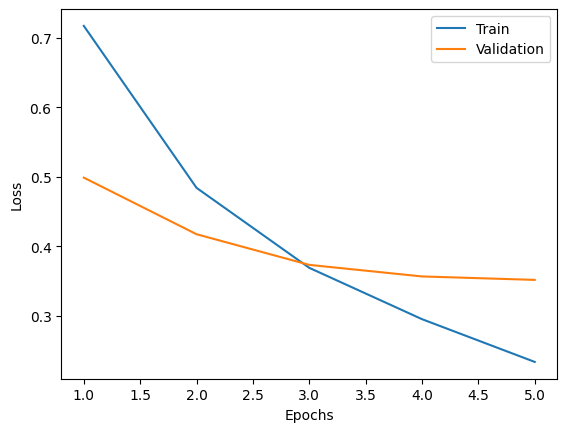

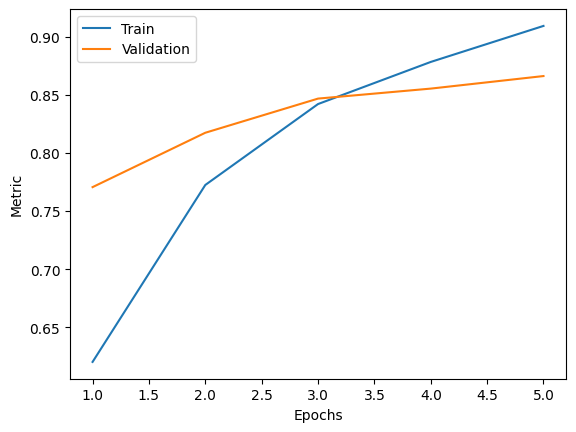

In [ ]:
plot_history(train_losses, train_acc, valid_losses, valid_acc)

# <Font color = 'indianred'>**Model Checkpointing**

In [ ]:
# Get the current timestamp in the format "YYYY-MM-DD_HH-MM-SS"
timestamp = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")

# Define a suffix for the file name
suffix = 'twolayer'

# Combine the timestamp and suffix to create the file path
path = model_folder / f'{timestamp}_{suffix}.pt'
path

PosixPath('/content/drive/MyDrive/data/models/nlp_fall_2023/imdb/nn/2023-09-18_09-25-10_twolayer.pt')

In [ ]:
# Save the model's state dictionary to the specified file path
torch.save(model_imdb.state_dict(), path)


In [ ]:
# Create an instance of the model with the same architecture
my_model = CustomMLP(vocab_size=hyperparameters.VOCAB_SIZE,
                       embedding_dim=hyperparameters.EMBED_DIM,
                       hidden_dim1=hyperparameters.HIDDEN_DIM1,
                       hidden_dim2=hyperparameters.HIDDEN_DIM2,
                       drop_prob1=hyperparameters.DROP_PROB1,
                       drop_prob2=hyperparameters.DROP_PROB2,
                       num_outputs=hyperparameters.NUM_OUTPUTS)

# Load the model's state dictionary from the specified checkpoint file
checkpoint = torch.load(path)

# Load the saved state dictionary into the model
my_model.load_state_dict(checkpoint)


<All keys matched successfully>

# <Font color = 'indianred'>**Get Accuracy, Predictions**

In [ ]:
def get_acc_pred(data_loader, model, device):
    """
    Function to get predictions and accuracy for a given data using a trained model
    Input: data iterator, model, device
    Output: predictions and accuracy for the given dataset
    """
    model = model.to(device)
    # Set model to evaluation mode
    model.eval()

    # Create empty tensors to store predictions and actual labels
    predictions = torch.Tensor().to(device)
    y = torch.Tensor().to(device)

    # Iterate over batches from data iterator
    with torch.no_grad():
        for inputs, targets in data_loader:
            # Process the batch to get the loss, outputs, and correct predictions
            outputs, _ = step(inputs, targets, model,
                              device, loss_function=None, optimizer=None)

            # Choose the label with maximum probability
            _, predicted = torch.max(outputs.data, 1)

            # Add the predicted labels and actual labels to their respective tensors
            predictions = torch.cat((predictions, predicted))
            y = torch.cat((y, targets.to(device)))

    # Calculate accuracy by comparing the predicted and actual labels
    accuracy = (predictions == y).float().mean()

    # Return tuple containing predictions and accuracy
    return predictions, accuracy

In [ ]:
# Get the prediction and accuracy
predictions_test, acc_test = get_acc_pred(test_loader, my_model, device)
predictions_train, acc_train = get_acc_pred(train_loader, my_model, device)
predictions_valid, acc_valid = get_acc_pred(valid_loader, my_model, device)

In [ ]:
# Print Test Accuracy
print('Test accuracy', acc_test * 100)
print('Train accuracy', acc_train * 100)
print('Valid accuracy', acc_valid * 100)

Test accuracy tensor(85.0520, device='cuda:0')
Train accuracy tensor(95.1500, device='cuda:0')
Valid accuracy tensor(86.6200, device='cuda:0')


# <Font color = 'indianred'>**Confusion Matrix for Test Data**

Now, we will make some visualizations for the predictions that we obtained.

We will construct a `confusion matrix` which will help us to visualize the performance of our classification model on the test dataset as we know the true values for the test data.

In [ ]:

# Define the human-readable class labels corresponding to the numerical class indices
classes = ['negative', 'positive']

# Get an array containing actual labels from the testing dataset
testing_labels = np.array(testset.y)

# Compute the confusion matrix between actual labels and predicted labels
cm = confusion_matrix(testing_labels, predictions_test.cpu(), normalize='true')

# Create a ConfusionMatrixDisplay object for visualization with class labels
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)


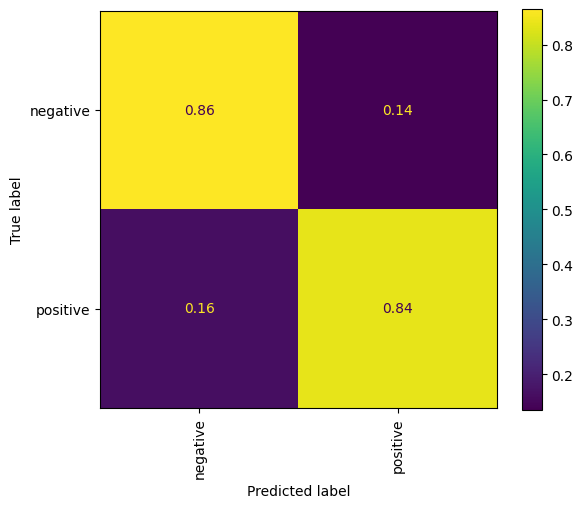

In [ ]:
# Create the confusion matrix plot
ax = disp.plot().ax_

# Rotate x-axis labels
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

# Access the Matplotlib figure from the Axes object and set its size

# Get the current figure
fig = plt.gcf()

# Remove the last (existing) color bar
plt.delaxes(fig.axes[-1])
ax.figure.set_size_inches(8, 8)

# Modify the colorbar size
ax.figure.colorbar(ax.images[0], ax=ax, shrink=0.65)  # 'shrink' parameter adjusts the size

plt.show()